# CNN Model for 1D
## Develop 1D Convolutional Neural Network

Reference: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/


We start by talking about what exactly is convolution, in particular convolution in 1D

We define an input 1d column matrix called as feature vector
and another column matrix filter/weights. 

The result is another column matrix we define it to be Feature Map.

For each element fm_i, in feature map, at index i, we can write 

fm_i = sum ( fv_j * w_k )
in shorter terms fm = fv * w (convolution)

j varying over i and i + w.size
and 
k varying over 0 and w.size

This elementarily defines convolution of 2 column matrices, that is the feature vector and weights.
This defines single layer convolution, that is a non deep CNN.

However if we talk about multiple layers we take the feature map of one layer 
as the feature vector for the next layer and a maybe different filter/weights 
column vector. The same can go on for a few layers.


![Alternative text](convolution.png)

Reference for explanation 
https://www.youtube.com/watch?v=yd_j_zdLDWs

Here we now talk about what has been implemented, that is CNN to do activity recognition

Idea is to do activity recognition 
output to be given as a number bwn 1-6 denoting 

1 WALKING

2 WALKING_UPSTAIRS

3 WALKING_DOWNSTAIRS

4 SITTING

5 STANDING

6 LAYING

We have 9 inputs, that is features, body acceleration in all 3 directions, body angular velocity in all 3 directions and the total acceleration in all 3 directions

Further, each series of data has been partitioned into overlapping windows of 2.65 seconds of data, or 128 time steps
and we have 7352 such example time series.

Correspondingly we get the result of type of activity being done, as described by the above 6 actions

In [251]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
# removed .convolutional from the above 2 imports
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

In [252]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		dataframe = read_csv((prefix + name), header = None, sep='\s+')
		data = dataframe.values
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix='./'):
	filepath = prefix + group + '/InertialSignals/'
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	print('filenames', filenames)
	# load class output
	y_dataframe = read_csv((prefix + group + '/y_'+group+'.txt'), header = None, sep='\s+')
	y = y_dataframe.values
	return X, y

In [253]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

In [254]:
scores = list()
repeats = 5
# TODO: change repeats to 10 while submitting
trainX, trainy, testX, testy = load_dataset()

filenames ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt', 'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
filenames ['total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt', 'body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']


In [255]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, summary = False):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	print(n_timesteps, n_features, n_outputs)
	model = Sequential()
	# 2 Layer Neural Networks
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	#output classification
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	if(summary): return model.summary(), accuracy
	return None, accuracy

In [256]:
for r in range(repeats):
    if(r == 0):
        df_trainX = trainX
        df_trainY = trainy
        df_testX = testX
        df_testY = testy
    summary, score = evaluate_model(trainX, trainy, testX, testy)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
# summarize results
print(scores)
m, s = mean(scores), std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# about 91% accuracy, is pretty good

128 9 6


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>#1: 92.229
128 9 6
>#2: 91.144
128 9 6
>#3: 92.128
128 9 6
>#4: 89.990
128 9 6
>#5: 89.786
[92.22938418388367, 91.14353656768799, 92.12758541107178, 89.98982310295105, 89.78622555732727]
Accuracy: 91.055% (+/-1.028)


Lets Dive Deeper, have shown EDA Exploratory Data analysis down below of the data for a particular data sample

In [257]:
#BAD Practice to have same names!
df_trainX = pd.DataFrame(df_trainX[0])
df_trainY = pd.DataFrame(df_trainY[0])
df_testX = pd.DataFrame(df_testX[0])
df_testY = pd.DataFrame(df_testY[0])

In [258]:
df_trainX.rename(columns = {
    0:'total_acc_x_train',
    1:'total_acc_y_train',
    2:'total_acc_z_train',
    3:'body_acc_x_train',
    4:'body_acc_y_train',
    5:'body_acc_z_train',
    6:'body_gyro_x_train',
    7:'body_gyro_y_train',
    8:'body_gyro_z_train'
}, inplace=True)
df_trainX

,total_acc_x_train,total_acc_y_train,total_acc_z_train,body_acc_x_train,body_acc_y_train,body_acc_z_train,body_gyro_x_train,body_gyro_y_train,body_gyro_z_train
0,1.012817,-0.123217,0.102934,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859
1,1.022833,-0.126876,0.105687,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316
2,1.022028,-0.124004,0.102102,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250
3,1.017877,-0.124928,0.106553,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751
4,1.023680,-0.125767,0.102814,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553
...,...,...,...,...,...,...,...,...,...
123,1.019815,-0.127010,0.094843,0.000228,-0.002929,-0.003412,0.025197,-0.005166,0.007355
124,1.019290,-0.126185,0.098350,-0.000300,-0.002023,0.000359,0.032328,-0.001298,0.002669
125,1.018445,-0.124070,0.100385,-0.001147,0.000171,0.002648,0.039852,0.001909,-0.002170
126,1.019372,-0.122745,0.099874,-0.000222,0.001574,0.002381,0.037449,-0.000080,-0.005643


The variation in the inputs is as follows

<Axes: >

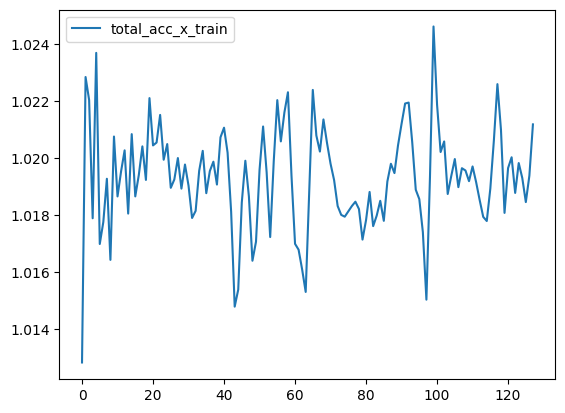

In [259]:
df_trainX.plot(y=['total_acc_x_train'])

<Axes: >

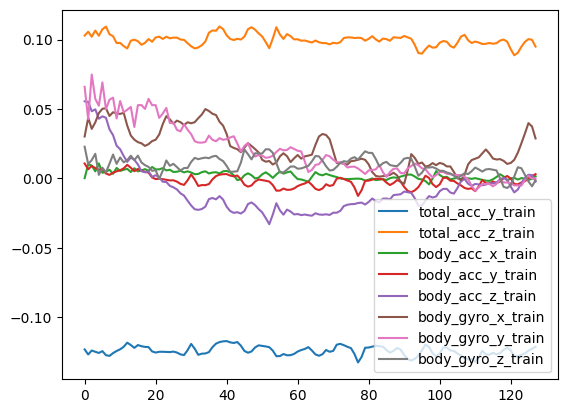

In [260]:
df_trainX.plot(y=['total_acc_y_train', 'total_acc_z_train', 'body_acc_x_train', 'body_acc_y_train', 'body_acc_z_train', 'body_gyro_x_train', 'body_gyro_y_train', 'body_gyro_z_train'])

Output is a single size 6 column vector that shows the activity in the 128 timesteps - time frame

Idea is that the model scans through the 9 values across 128 data points or time steps and gives out result as a single number.

An explanation of the function evaluate_model is as:

The (num_samples,time-steps,9) input data is fed to the Sequential CNN Model.

We have ReLU (Rectified Linear Unit) as the activation function that outputs the input directly if it's positive, otherwise outputs zero.

For the Conv1D layers, the kernel size is set at 3 and the number of filters is set at 64. Thus, we run convolution across timestep 64 times, and stack the outputs of each of the kernel to obtain the output of the conv1D layer.

After that, we apply dropout regularization to avoid overfitting and increase robustness of the model.

Maxpooling1D layer has no parameters, and is used to downsample the output which is then passed to the flatten layer, which squeezes the input into a 1 dimensional vector for each data sample.
The 1 dimensional vector is fed to dense feed-forward layers. The last layer has softmax activation to obtain probabilities of every class as the final output of the Sequential Keras model.

![Alternative text](ConvTime.png)

For more insights we can take a look inside the model summary.

First lets run a particular sample, and see its model summary

In [261]:
summary, score = evaluate_model(trainX, trainy, testX, testy, True)
score = score * 100.0
print('>#%d: %.3f' % (r+1, score))

128 9 6


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_225 (Conv1D)             │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_226 (Conv1D)             │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_111               │ (None, 62, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_111 (Flatten)           │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 100)            │       396,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,234,952 (4.71 MB)

 Trainable params: 411,650 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 823,302 (3.14 MB)

>#5: 90.601


First 2 layers are responsible for taking input size from 128 to 
128 - 3 (kernel size) + 1 = 126

126 - 3 (kernel size) + 1 = 124

From the output size of a convolutional layer.

Further we pass it through the pooling, which halves the size.

Then we flatten the data points, and then feed it to a dense feed forward network twice to result in a size 6 column matrix. That gives us final output, and gives us the result of the human activity being performed. 
